In [1]:
import numpy as np
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, ZeroPadding2D
from keras.layers.pooling import MaxPooling2D 
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

import csv
%matplotlib inline
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
vgg_mean = np.array([80, 97, 95], dtype=np.float32).reshape((1,1,3))
def vgg_preprocess(x):
    #print "a", x.shape
    x = x - vgg_mean
    #print x.shape
    #return x [:, ::-1] # reverse axis rgb->bgr
    return x

img_sz = 128

model = Sequential()
model.add(Lambda(vgg_preprocess, input_shape=(img_sz, img_sz,3), output_shape=(img_sz, img_sz,3)))
model.add(ZeroPadding2D(1))
model.add(Conv2D(16, 3,  activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(ZeroPadding2D(1))
model.add(Conv2D(32, 3,  activation = 'relu'))       
model.add(ZeroPadding2D(1))
model.add(Conv2D(32, 3,  activation = 'relu'))
model.add(ZeroPadding2D(1))
model.add(Conv2D(32, 3,  activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(ZeroPadding2D(1))
model.add(Conv2D(64, 3,  activation = 'relu'))       
model.add(ZeroPadding2D(1))
model.add(Conv2D(64, 3,  activation = 'relu'))       
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(ZeroPadding2D(1))
model.add(Conv2D(128, 3,  activation = 'relu'))       
model.add(ZeroPadding2D(1))
model.add(Conv2D(128, 3,  activation = 'relu'))       
model.add(ZeroPadding2D(1))
model.add(Conv2D(128, 3,  activation = 'relu'))       
#model.add(ZeroPadding2D(1))
#model.add(Conv2D(128, 3,  activation = 'relu'))       
model.add(ZeroPadding2D(1))
#model.add(Conv2D(256, 3,  activation = 'relu'))       
#model.add(ZeroPadding2D(1))
model.add(Conv2D(256, 3,  activation = 'relu'))       
model.add(MaxPooling2D(pool_size=(2, 2))) 


model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
#weights-improvement-55-0.99.hdf5weights-improvement-06-0.9
#model.load_weights("weights-improvement-16-0.98.hdf5")
print model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 130, 130, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 66, 66, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 66, 66, 32)        0         
__________

In [3]:
batch_size=32
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory('sub/totrain',
                                                 target_size = (img_sz, img_sz),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

val_set = val_datagen.flow_from_directory('sub/toval',
                                            target_size = (img_sz, img_sz),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')


Found 17467 images belonging to 10 classes.
Found 4957 images belonging to 10 classes.


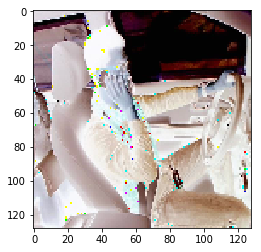

In [4]:
i = training_set.next()
plt.imshow(i[0][6])


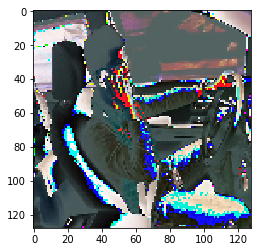

In [5]:
plt.imshow(vgg_preprocess(i[0][6]))

In [ ]:
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy', metrics=['categorical_accuracy'])
filepath="weights-improvement-{epoch:02d}-{categorical_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='categorical_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]



In [ ]:
model.fit_generator(training_set,
                         steps_per_epoch = training_set.samples /batch_size,
                         epochs = 1000,
                         validation_data = val_set,
                         validation_steps = val_set.samples /batch_size,
                         callbacks=callbacks_list)


Epoch 1/1000


In [ ]:
model.evaluate_generator(training_set, training_set.n/100)

In [ ]:
avg = np.zeros(3)
for i in range(1): #training_set.n/training_set.batch_size):
  data = training_set.next()
  d = data[0]
  #print d.shape
  #print avg, np.mean(data[0], axis=(0,1,2))
  avg = np.vstack([avg, np.mean(data[0], axis=(0,1,2))])
print avg


In [ ]:
np.mean(avg,axis=(0))

In [ ]:
submit_datagen = ImageDataGenerator() #'sub/test'
submit_set = submit_datagen.flow_from_directory('sub/test',
                                                target_size=(128,128),
                                                batch_size=1,
                                                class_mode=None,
                                                shuffle=False)

print submit_set.samples, submit_set.batch_size, submit_set.n
preds = model.predict_generator(submit_set, 
                                submit_set.n,
                                verbose=1
                               )
print len(preds)
assert len(preds) == len(submit_set.filenames)


In [ ]:
preds
with open('submission.csv', 'w') as csvfile:
  csvw = csv.writer(csvfile)
  csvw.writerow(['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
  for fn, sc in zip(submit_set.filenames, preds):
    csvw.writerow([fn.split('/')[1]] + list(sc))

In [ ]:
preds.shape

In [ ]:
#submit_datagen = ImageDataGenerator() #'sub/test'
#submit_set = submit_datagen.flow_from_directory('sub/test2', target_size= (32,32),batch_size=1, 
#                                                class_mode=None, shuffle=False)

#print "beginning", submit_set.batch_size, submit_set.batch_index, submit_set.n
#preds = model.predict_generator(submit_set, submit_set.n ,verbose=0)
#print submit_set.batch_size, submit_set.batch_index


In [ ]:
#submit_set.index_generator.next()

In [ ]:
##submit_set.filenames

In [ ]:
#preds